# MC-Dropout

## Theoretic Foundation

MC Dropout is presented in [Dropout as a Bayesian Approximation:
Representing Model Uncertainty in Deep Learning (Gal and Ghahramani 2016)](http://proceedings.mlr.press/v48/gal16.pdf) as an approximation of Baysian Neural Networks to estimate epistemic uncertainty. In [What Uncertainties Do We Need in Bayesian Deep
Learning for Computer Vision? (Kendall and Gal 2017)](https://proceedings.neurips.cc/paper/2017/file/2650d6089a6d640c5e85b2b88265dc2b-Paper.pdf) the approach is extended to include aleatoric uncertainty. 

The following is based on [Kendall and Gal 2017](https://proceedings.neurips.cc/paper/2017/file/2650d6089a6d640c5e85b2b88265dc2b-Paper.pdf). Here for regression problems the network output is modelled by $f_{\theta}(x) = (\mu_{\theta}(x), \sigma_{\theta}(x))$ where the network is parameterized by weights $\theta$. The network architecture contains a Dropout layer after each hidden layer. This means that the network's weights and biases are modelled as Bernulli distributions, i.e. the weights are dropped, as in set to zero, with probability $p$. A common choice for th dropout probability is $p=0.2$, but it can also be viewed as a hyperparameter that is optimized. Note that dropout has also been used for regularization, for example in [Learning Deep Networks from Noisy Labels with Dropout Regularization (Jindall et al. 2016)](https://ieeexplore.ieee.org/abstract/document/7837934).

The loss objective, the loss for batch size $m=1$, is chosen to be the negative log-likelihood of a Gaussian,

$-\log(p_{\theta}(y|x))=\frac{(y-\mu_{\theta}(x))^2}{2\sigma_{\theta}(x)^2}+\frac{\log(\sigma_{\theta}(x)^2)}{2}+\text{const.}$

This means that the likelihood of predicting $y$ given an input $x$ is maximized. Note that when SGD is used the constant can be omitted as the parameters are updated by the learning rate times the gradient of the loss. Hence, the constant vanishes. 

In order to obtain a predictive mean and uncertainty, Dropout is activated not only during training, but also at test time. This means that $M$ forward passes yield $M$ different outputs, as different weights are set to zero according to probability $p$.

Then, the mean of the $M$ forward passes can be computed as,

$\mu^*(x) = M^{-1} \sum_{i=1}^M \mu_{\theta_i}(x),$

and the variance can be approximated as,

$\sigma^*(x)^2 \approx M^{-1} \sum_{i=1}^M \mu_{\theta_i}(x)^2 - \mu^*(x)^2+ M^{-1} \sum_{i=1}^M \sigma_{\theta_i}(x)^2.$

The epistemic uncertainty is given by the variance of the model predictions,

$\sigma^*_{\textit{m}}(x)^2 \approx M^{-1} \sum_{i=1}^M \mu_{\theta_i}(x)^2 - \mu^*(x)^2.$

The aleatoric uncertainty is given by the mean of the variances predictions,

$\sigma^*_{\textit{d}}(x)^2 \approx M^{-1} \sum_{i=1}^M \sigma_{\theta_i}(x)^2.$

## Imports

In [1]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger
from torch.optim import Adam

from uq_method_box.datamodules import ToyHeteroscedasticDatamodule
from uq_method_box.models import MLP
from uq_method_box.uq_methods import NLL, MCDropoutModel
from uq_method_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions,
    plot_toy_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Global seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

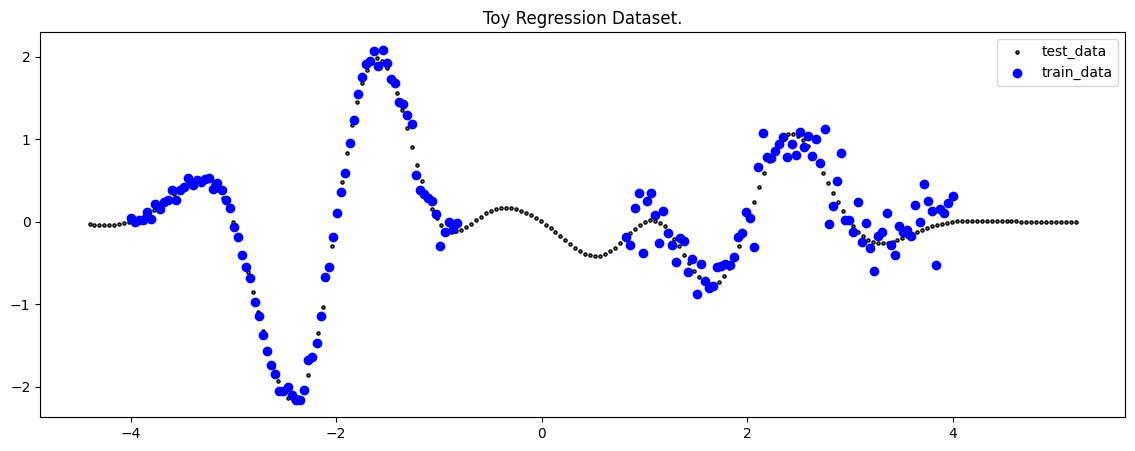

In [5]:
plot_toy_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://torchgeo.readthedocs.io/en/stable/api/models.html#MLP).

In [25]:
network = MLP(
    n_inputs=1,
    n_hidden=[50, 50, 50],
    n_outputs=2,
    dropout_p=0.2,
    activation_fn=nn.Tanh(),
)
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=50, out_features=2, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible.

In [34]:
max_epochs = 500
mc_dropout_module = MCDropoutModel(
    model=network,
    optimizer=partial(Adam, lr=1e-2),
    loss_fn=NLL(),
    num_mc_samples=25,
    burnin_epochs=50,
    max_epochs=max_epochs,
    save_dir=my_temp_dir,
)

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [35]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=max_epochs,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [36]:
trainer.fit(mc_dropout_module, dm)


  | Name          | Type             | Params
---------------------------------------------------
0 | train_metrics | MetricCollection | 0     
1 | val_metrics   | MetricCollection | 0     
2 | test_metrics  | MetricCollection | 0     
3 | model         | MLP              | 5.3 K 
4 | loss_fn       | NLL              | 0     
---------------------------------------------------
5.3 K     Trainable params
0         Non-trainable params
5.3 K     Total params
0.021     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/t

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

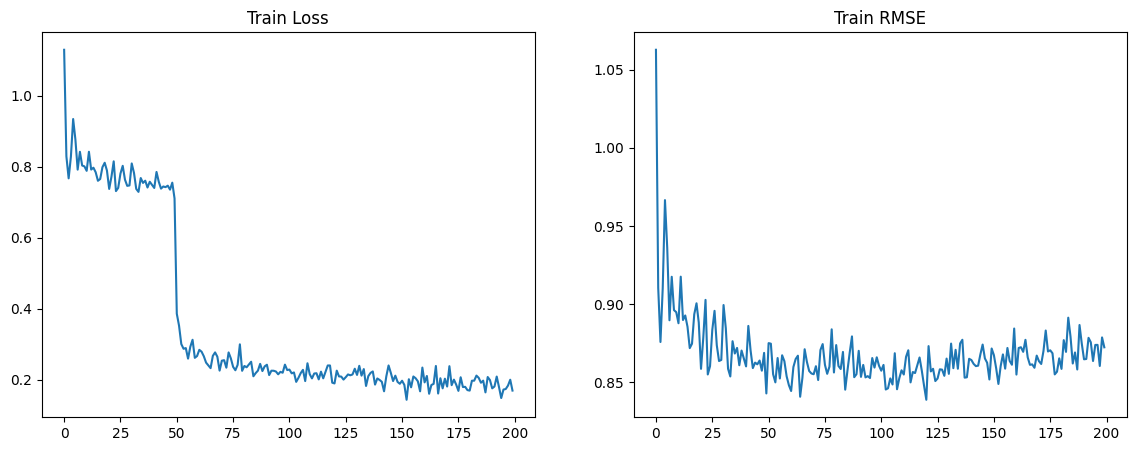

In [37]:
fig = plot_training_metrics(my_temp_dir)

## Prediction

For prediction we can either rely on the `trainer.test()` method or manually conduct a `predict_step()`. Using the trainer will save the predictions and some metrics to a CSV file, while the manual `predict_step()` with a single input tensor will generate a dictionary that holds the mean prediction as well as some other quantities of interest, for example the predicted standard deviation or quantile.

In [38]:
# save predictions
trainer.test(mc_dropout_module, dm.test_dataloader())

/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[{}]

In [39]:
preds = mc_dropout_module.predict_step(X_test)
preds.keys()

dict_keys(['mean', 'pred_uct', 'epistemic_uct', 'aleatoric_uct', 'lower_quant', 'upper_quant'])

## Evaluate Predictions

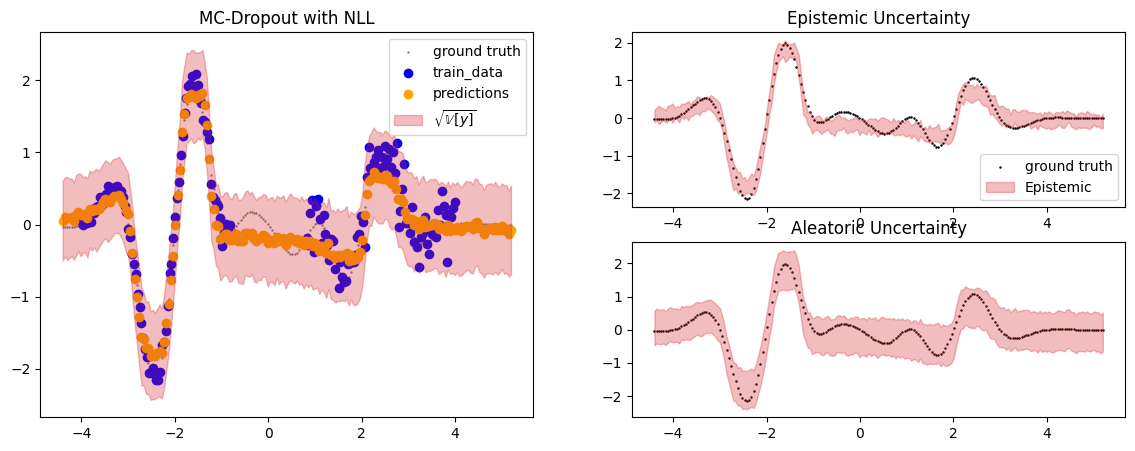

In [40]:
fig = plot_predictions(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["mean"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="MC-Dropout with NLL",
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

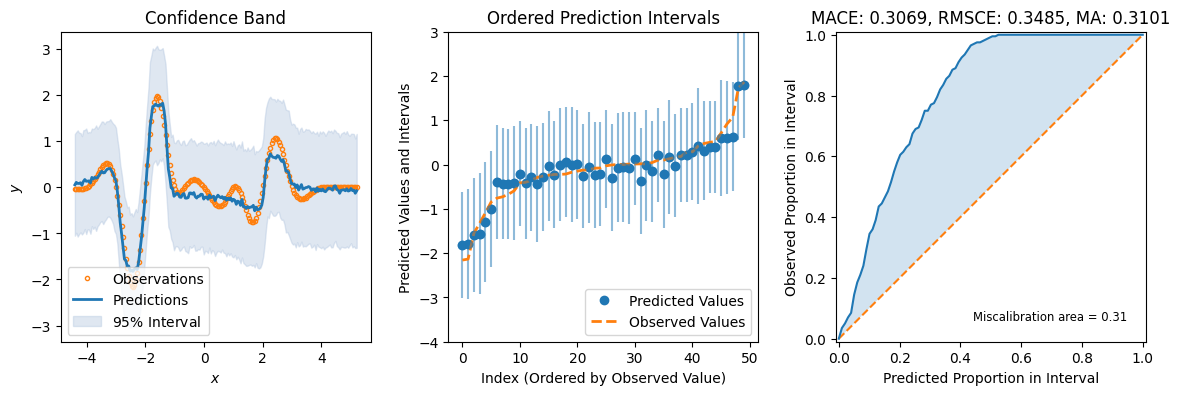

In [41]:
fig = plot_calibration_uq_toolbox(
    preds["mean"], preds["pred_uct"], y_test.cpu().numpy(), X_test.cpu().numpy()
)

## Additional Resources

Note that there has been an on-going discussion about the interpretation of MC Dropout as a Baysian Method and, further, its meaningfulness to quantify uncertainty, [Risk versus Uncertainty in Deep Learning:
Bayes, Bootstrap and the Dangers of Dropout (Osband 2016)](http://bayesiandeeplearning.org/2016/papers/BDL_4.pdf). Moreover, some authors have claimed that MC Dropout is inherently not a Baysian method, [Variational Gaussian Dropout is not Bayesian (Hron et al. 2017)](http://bayesiandeeplearning.org/2017/papers/45.pdf).